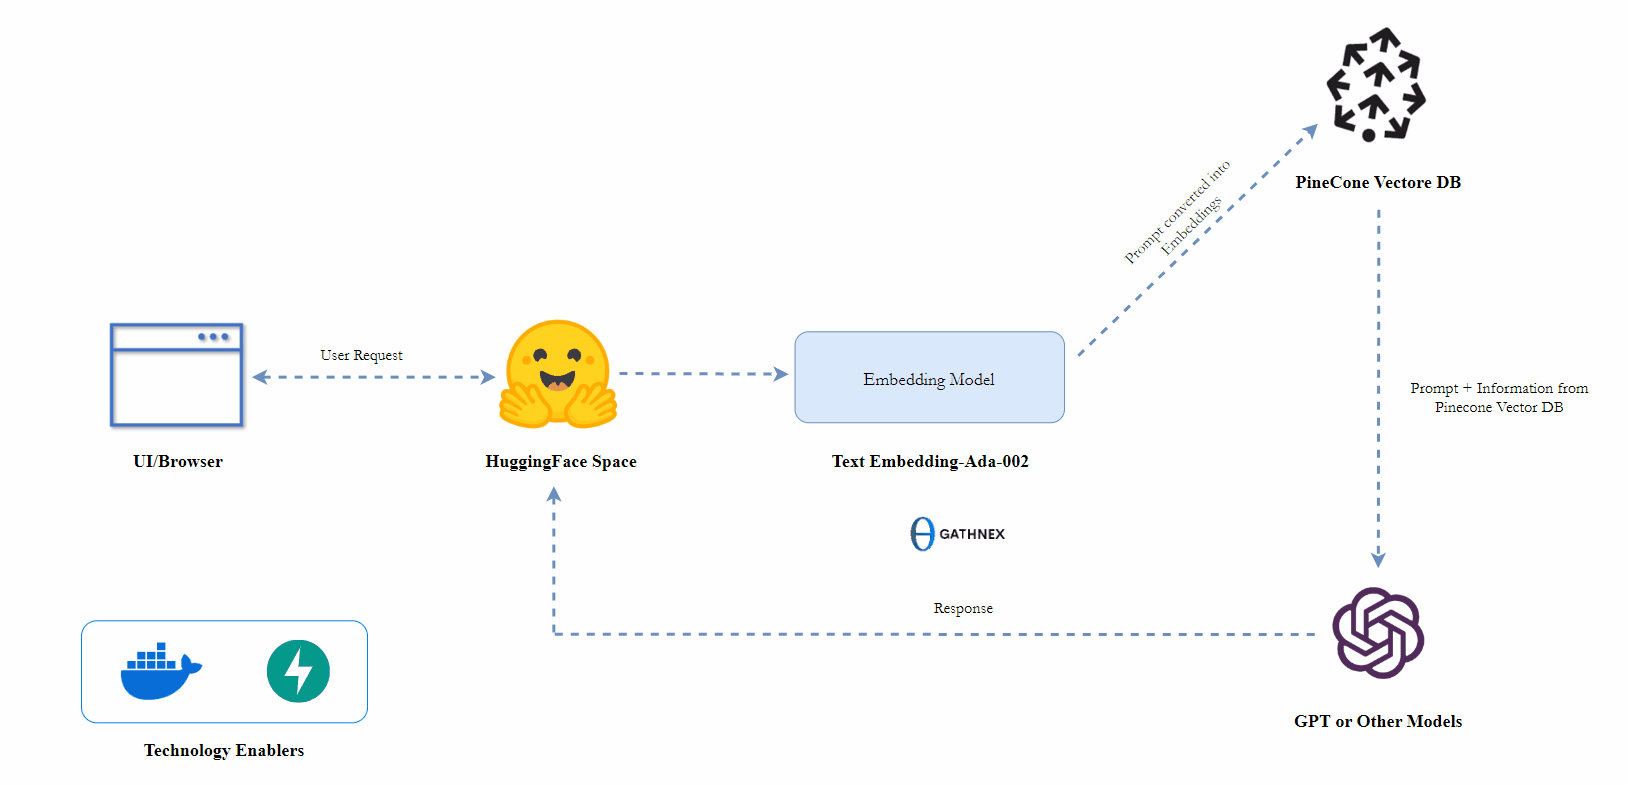

We first need to setup our environment and retrieve API keys for OpenAI and Pinecone. Let's start with our environment, we need HuggingFace *Datasets* for our data, and the OpenAI and Pinecone clients:

In [ ]:
!pip install -q pinecone-client openai datasets cohere

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.4/179.4 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.8/220.8 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.4/300.4 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 68.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.3 MB/s eta 0:00:00
ERROR: pip's dependency 

### Creating Embeddings

Then we initialize our connection to OpenAI Embeddings *and* Pinecone vector DB. Sign up for an API key over at [OpenAI](https://beta.openai.com/signup) and [Pinecone](https://app.pinecone.io).

In [ ]:
from openai import OpenAI
from google.colab import userdata
import os

client = OpenAI(api_key= userdata.get('OPENAI_API_KEY')) #Add a api key and other variables in Secret

We can now create embeddings with the OpenAI Ada similarity model like so:

In [ ]:
res = client.embeddings.create(
    input=[
        "The Gathnex AI community is a group of individuals who are interested in learning about and using AI. The community is open to anyone who wants to participate, and there are no prerequisites for membership. The community is a great place to learn about AI, share your experiences, and connect with other like-minded individuals.",
    ],
    model="text-embedding-ada-002"
)
print(res.data[0].embedding)

[0.0018979301676154137, -0.005342443939298391, 0.00022287546016741544, -0.02531011402606964, -0.02419368550181389, 0.022039633244276047, -0.006705144420266151, 0.008931436575949192, 0.009620996192097664, -0.03044569119811058, 0.02207903563976288, 0.0024068907368928194, 0.025323249399662018, -0.029736429452896118, 0.004117654636502266, -0.004262133967131376, 0.02139604464173317, -0.010021597146987915, 0.01117086224257946, -0.0006977684679441154, -0.008589940145611763, 0.02139604464173317, -0.004258850123733282, -0.008018591441214085, -0.013436557725071907, 0.0016065093223005533, 0.018138697370886803, -0.021199027076363564, 0.008373221382498741, -0.015932105481624603, 0.016365543007850647, -0.005549311637878418, 0.0071911197155714035, -0.015577475540339947, 0.002792715560644865, 0.011289073154330254, 0.012018036097288132, -0.01742943562567234, 0.023497559130191803, 0.0008570238715037704, 0.010494438000023365, 0.006514694541692734, 0.003391975536942482, -0.020529169589281082, 0.0106126479

In [ ]:
print(f"vector 0: {len(response.embeddings[0])} Size")

vector 0: 1024 Size


In [ ]:
import pinecone

index_name = 'rag-demo'

# initialize connection to pinecone (get API key at app.pinecone.io)
pinecone.init(
    api_key =  userdata.get('pinecone_api'),
    environment = "gcp-starter"  # find next to api key in console
)
# check if 'openai' index already exists (only create index if not)
if index_name not in pinecone.list_indexes():
    pinecone.create_index(index_name, dimension=len(res.data[0].embedding))
# connect to index
index = pinecone.Index(index_name)

/usr/local/lib/python3.10/dist-packages/pinecone/index.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Populating the Index

Now we will take 1K questions from the TREC dataset

In [ ]:
from datasets import load_dataset

# load the first 150 rows of the TREC dataset
data = load_dataset('nisaar/Lawyer_GPT_India', split='train')
data

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['question', 'answer'],
    num_rows: 150
})

Then we create a vector embedding for each phrase using OpenAI, and `upsert` the ID, vector embedding, and original text for each phrase to Pinecone.

In [ ]:
from tqdm.auto import tqdm
import time

count = 0  # we'll use the count to create unique IDs
batch_size = 1  # process everything in batches of 32
for i in tqdm(range(0, len(data['answer']), batch_size)):
    # set end position of batch
    i_end = min(i+batch_size, len(data['answer']))
    # get batch of lines and IDs
    lines_batch = data['answer'][i: i+batch_size]
    ids_batch = [str(n) for n in range(i, i_end)]
    # create embeddings
    res = client.embeddings.create(input=lines_batch,model="text-embedding-ada-002")
    time.sleep(20)
    embeds = [res.data[0].embedding]
    # prep metadata and upsert batch
    meta = [{'text': line} for line in lines_batch]
    to_upsert = zip(ids_batch, embeds, meta)
    # upsert to Pinecone
    index.upsert(vectors=list(to_upsert))

  0%|          | 0/150 [00:00<?, ?it/s]

---

# Querying

With our data indexed, we're now ready to move onto performing searches. This follows a similar process to indexing. We start with a text `query`, that we would like to use to find similar sentences. As before we encode this with OpenAI's text similarity Babbage model to create a *query vector* `xq`. We then use `xq` to query the Pinecone index.

In [ ]:
query = "transportation law"
xq = client.embeddings.create(input=query,model="text-embedding-ada-002")
res = index.query([xq.data[0].embedding], top_k=2, include_metadata=True)
res

{'matches': [{'id': '78',
              'metadata': {'text': 'The Motor Vehicles (Amendment) Act, 2019 '
                                   'has substantial implications for road '
                                   'safety. It increases penalties for traffic '
                                   'violations, introduces provisions for '
                                   'electronic enforcement, and provides for a '
                                   'Motor Vehicle Accident Fund. It also '
                                   'mandates the central government to '
                                   'regulate taxi aggregators and establishes '
                                   'a National Road Safety Board. This Act is '
                                   'expected to enhance compliance with '
                                   'traffic rules and reduce road accidents.'},
              'score': 0.805287659,
              'values': []},
             {'id': '8',
              'metadata': {'t

In [ ]:
def Vector_search(query):
  Rag_data = ""
  xq = client.embeddings.create(input=query,model="text-embedding-ada-002")
  res = index.query([xq.data[0].embedding], top_k=2, include_metadata=True)
  for match in res['matches']:
      if match['score'] < 0.80:
        continue
      Rag_data += match['metadata']['text']
  return Rag_data

The response from Pinecone includes our original text in the `metadata` field, let's print out the `top_k` most similar questions and their respective similarity scores.

### **Without**  **RAG**

In [ ]:
#GPT Completion
def GPT_completion(prompt):
    DEFAULT_SYSTEM_PROMPT = '''You are a helpful, respectful and honest INTP-T AI Assistant named Gathnex AI. You are talking to a human User.
    Always answer as helpfully and logically as possible, while being safe. Your answers should not include any harmful, political, religious, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.
    If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
    You can speak fluently in English
    '''
    response = client.chat.completions.create(
    model="gpt-3.5-turbo-1106",
    messages=[
        {f"role": "system", "content": DEFAULT_SYSTEM_PROMPT},
        {f"role": "user", "content": prompt},
    ]
    )
    return response.choices[0].message.content

In [ ]:
GPT_completion("tell about article 32 in indian law")

'Article 32 of the Indian Constitution guarantees the right to constitutional remedies. It allows individuals to directly approach the Supreme Court of India for enforcement of their fundamental rights. Essentially, this article empowers the Supreme Court to issue writs for the enforcement of fundamental rights, making it a fundamental right in itself. This provision plays a crucial role in safeguarding individual rights and ensuring access to justice for citizens.'

### **With**  **RAG**

In [ ]:
#GPT Completion
def GPT_completion_with_vector_search(prompt):
    DEFAULT_SYSTEM_PROMPT = '''You are a helpful, respectful and honest INTP-T AI Assistant named Gathnex AI. You are talking to a human User.
    Always answer as helpfully and logically as possible, while being safe. Your answers should not include any harmful, political, religious, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.
    If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
    You also have access to RAG vectore database access which has Indian Law data. Be careful when giving response, sometime irrelevent Rag content will be there so give response effectivly to user based on the prompt.
    You can speak fluently in English
    '''
    rag = Vector_search(prompt)
    response = client.chat.completions.create(
    model="gpt-3.5-turbo-1106",
    messages=[
        {f"role": "system", "content": DEFAULT_SYSTEM_PROMPT},
        {f"role": "user", "content": rag +", Prompt: "+ prompt},
    ]
    )
    return response.choices[0].message.content

In [ ]:
GPT_completion_with_vector_search("tell about article 32 in indian law")

'Article 32 of the Indian Constitution is widely regarded as the "Heart and Soul of the Constitution." It provides citizens with the right to seek constitutional remedies from the Supreme Court to enforce their Fundamental Rights. This provision acts as the guardian of Fundamental Rights, ensuring that they are not just enshrined in the Constitution, but also protected and enforced.\n\nArticle 32 empowers individuals to directly approach the Supreme Court for the enforcement of their Fundamental Rights, making these rights meaningful and effective. This constitutional provision is instrumental in safeguarding the rights of citizens and ensuring that they are not deprived of their life or personal liberty except according to the procedure established by law, as outlined in Article 21. Therefore, Article 32 plays a crucial role in upholding the rule of law and protecting the rights and liberties of individuals in India.'

Looks good, let's make it harder and replace *"depression"* with the incorrect term *"recession"*.

Looks great, our semantic search pipeline is clearly able to identify the meaning between each of our queries and return the most semantically similar questions from the already indexed questions.

Once we're finished with the index we delete it to save resources.

---